In [100]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import os
from collections import defaultdict 
import random

### This notebook is to train a physics based machine learning model on Volk et al benchmark ET but with a twist. 
We are using a merging of SEBAL and Sentinel-1 radar backscatter data
- We will first qulaity control the data based on the model outputs 
- In this model we will not use H, LE and G as inputs because they contain the most amount of errors(We can add them if required because the number of datapoints has drastically reduced) 


In [101]:
## Read the datasets, remoeve shady values and perform a random forest 
os.chdir("D:\\Backup\\Rouhin_Lenovo\\US_project\\Untitled_Folder\\Data\\Volk_merged\\ML_datasets\\Volk_SEBLA_Sen5\\")
file_list=os.listdir()
et_data=[]
for i in range(len(file_list)):
    et_data.append(pd.read_csv(file_list[i],parse_dates=["Date"]))
    et_data[i]=et_data[i][et_data[i]["Hinst"]<1500]
    et_data[i]=et_data[i][et_data[i]["LEinst"]>=0]
    et_data[i]["Gap"]=et_data[i]["Gap"].replace(np.NAN,0)


In [102]:
pd.concat(et_data).shape[0]

2878

In [103]:
## Instead on concatenating the data we will split the data clustered on landcover (This has an issue that we might be using spatial autocorrelated datasets for predction)
stations_lc=[]
count=[]
for i in pd.concat(et_data)["Land_cover_volk"].unique():
    counter=0
    for st in range(len(et_data)):
        if i==et_data[st]["Land_cover_volk"].iloc[0]:
            counter=counter+1
    count.append(counter)
print(count)

[29, 3, 3, 4, 12, 8, 1, 10, 5, 3]


In [104]:
## Now let's try to create a dictionary of Site ID and land cover so that we can trunce around the data 
site_id=[]
landcover=[]
for i in range(len(et_data)):
    site_id.append(et_data[i]["Site_name"].iloc[0])
    landcover.append(et_data[i]["Land_cover_volk"].iloc[0])
station_landcover_dict  = {k: v for k, v in zip(site_id, landcover)}
# Group stations by landcover
landcover_groups = defaultdict(list)
for station, landcover in station_landcover_dict.items():
    landcover_groups[landcover].append(station)
print("Before shuffling")
print(landcover_groups)
## Set random seed
random.seed(6)
for landcover, stations in landcover_groups.items():
    random.shuffle(stations)
print(landcover_groups)


Before shuffling
defaultdict(<class 'list'>, {'Annual crops': ['ALARC2_Smith6', 'Ellendale', 'JPL1_Smith5', 'LYS_NE', 'LYS_NW', 'LYS_SE', 'LYS_SW', 'manilacotton', 'S2', 'stonevillesoy', 'UA1_HartFarm', 'UA1_JV187', 'UA3_JV108', 'US-A74', 'US-ARM', 'US-Bi1', 'US-Bi2', 'US-IB1', 'US-KLS', 'US-MC1', 'US-OF1', 'US-OF2', 'US-Ro1', 'US-Ro2', 'US-Ro5', 'US-Ro6', 'US-Tw3', 'US-Twt', 'US-xSL'], 'Orchards': ['Almond_High', 'Almond_Low', 'Almond_Med'], 'Vineyards': ['BAR012', 'RIP760', 'SLM001'], 'Vegetable crops': ['JPL1_JV114', 'UA1_KN18', 'UA2_KN20', 'UA3_KN15'], 'Grasslands': ['US-A32', 'US-Hn2', 'US-IB2', 'US-KM4', 'US-Ro4', 'US-SRG', 'US-Var', 'US-Wkg', 'US-xAE', 'US-xDC', 'US-xDS', 'US-xNG'], 'Shrublands': ['US-ADR', 'US-Hn3', 'US-Jo2', 'US-Rwf', 'US-Rws', 'US-SRM', 'US-SRS', 'US-xJR'], 'Riparian': ['US-CMW'], 'Evergreen Forests': ['US-CZ3', 'US-GLE', 'US-Me2', 'US-Me6', 'US-NC2', 'US-NC3', 'US-NR1', 'US-xRM', 'US-xSB', 'US-xYE'], 'Mixed Forests': ['US-MOz', 'US-WCr', 'US-xDL', 'US-xST', 

In [105]:
# Initialize the final training and validation sets
train_stations = []
val_stations = []

# Include at least one station of each landcover in the validation set
for landcover, stations in landcover_groups.items():
    val_stations.extend(stations[:len(stations)//4])  # Add 25% of stations to validation set
    train_stations.extend(stations[len(stations)//4:]) # Add the rest to training set

# Shuffle the final training and validation sets
# random.shuffle(train_stations)
# random.shuffle(val_stations)
print("No of Val stations=",len(val_stations))
print("No of Train stations=",len(train_stations))
## Create workflow to re read the train and validation datasets 
train,val=[],[]
for i in range(len(et_data)):
    for j in train_stations:
        if et_data[i]["Site_name"].iloc[0]==j:
            train.append(et_data[i])
for i in range(len(et_data)):
    for j in val_stations:
        if et_data[i]["Site_name"].iloc[0]==j:
            val.append(et_data[i])
print("no of training points=",pd.concat(train).shape[0])
print("no of val points=",pd.concat(val).shape[0])

No of Val stations= 16
No of Train stations= 62
no of training points= 2164
no of val points= 714


<Axes: >

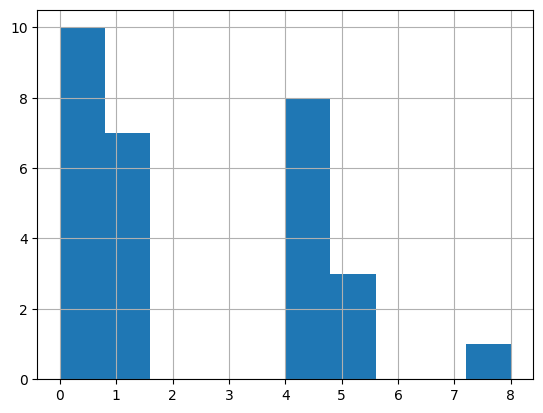

In [113]:
train[5].Gap.hist()

### Keras

In [124]:
train[0].columns

Index(['Unnamed: 0', 'Unnamed: 0_x', 'Date', 'B', 'R', 'GR', 'NIR', 'SWIR_1',
       'SWIR_2', 'ST_B10', 'NDVI', 'NDWI', 'ALFA', 'Tao_sw_1', 'Rs_down',
       'Rl_down', 'Rl_up', 'Rn', 'Ginst', 'Hinst', 'LEinst', 'LE_closed',
       'LE_Daily_model', 'Rn24h_G', 'AirT_G', 'RH_G', 'ux_G', 'Lat_volk',
       'Lon_volk', 'Elev_volk', 'Land_cover_volk', 'Site_name', 'Unnamed: 0_y',
       'longitude', 'latitude', 'date', 'VV', 'VH', 'angle', 'Gap', 'VV_norm',
       'VH_norm', 'VV_red', 'VV_green', 'VV_blue', 'VV_NIR', 'VV_SWIR1',
       'VV_SWIR2', 'VV_NDVI', 'VV_NDWI', 'VH_red', 'VH_green', 'VH_blue',
       'VH_NIR', 'VH_SWIR1', 'VH_SWIR2', 'VH_NDVI', 'VH_NDWI', 'VH_LST',
       'VV_LST', 'VH-VV'],
      dtype='object')

In [125]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
## Split data into features and labels
features=['ALFA', 'Tao_sw_1', 'Rs_down',
       'Rl_down', 'Rl_up', 'Rn','VV_norm', 
       'VH_norm', 'VV_red', 'VV_green', 'VV_blue', 'VV_NIR', 'VV_SWIR1',
       'VV_SWIR2', 'VV_NDVI', 'VV_NDWI', 'VH_red', 'VH_green', 'VH_blue',
       'VH_NIR', 'VH_SWIR1', 'VH_SWIR2', 'VH_NDVI', 'VH_NDWI', 'VH_LST',
       'VV_LST', 'VH-VV',"Ginst","Hinst","LE_Daily_model"]
labels=["LE_closed"]
## Create a train set to include the geesebal output 
train_features_all=pd.concat(train)[features].dropna()
test_features_all=pd.concat(val)[features].dropna()
train_features=pd.concat(train)[features].dropna().drop(columns="LE_Daily_model")
train_features
test_features=pd.concat(val)[features].dropna().drop(columns="LE_Daily_model")
scaler = StandardScaler()
X_train = scaler.fit_transform(train_features)
X_test = scaler.transform(test_features)
# ## labels
train_labels=np.array(pd.concat(train)[labels])
test_labels=np.array(pd.concat(val)[labels]).squeeze()

train_features_all.shape
test_labels.shape

(714,)

In [126]:
train_features_all.shape
test_features_all.shape

(714, 30)

In [127]:
from sklearn.metrics import root_mean_squared_error 
def rmse(Y_actual,Y_Predicted):
    return root_mean_squared_error(Y_actual,Y_Predicted)
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(( Y_Predicted-Y_actual))*100/np.mean(Y_actual)
    return mape
rmse(pd.concat(train)[(pd.concat(train)["LEinst"].notna())]["LE_closed"],pd.concat(train)[(pd.concat(train)["LEinst"].notna())]["LE_Daily_model"])/28.36
# MAPE(ml_df[(ml_df["LEinst"].notna())]["LE_inst_af"],ml_df[(ml_df["LEinst"].notna())]["LEinst"])

1.7986345210873578

In [128]:
## Vanilla neural network
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.utils.layer_utils import count_params
from keras import backend as K
from sklearn.metrics import r2_score

class NN:
    def __init__(self, input_shape):
        self.model = self.create_model(input_shape)

    def create_model(self, input_shape):
        layers = list()
        layers.append( tf.keras.layers.Flatten() )
        units = [ 128,128,128,128,128,128,128,128,128,64]
        for i in range( 10 ):
            if i==0:
                layers.append( tf.keras.layers.Dense( units[i] , activation='relu',input_shape=input_shape ) )
            else:
                layers.append( tf.keras.layers.Dense( units[i] , activation='relu') )
        layers.append(tf.keras.layers.Dense(1))
        model = keras.Sequential(layers)
        # model.add
        # model = Sequential([
        #     Dense(64, activation='relu', input_shape=input_shape),
        #     Dense(64, activation='relu'),
        #     Dense(64,activation="relu"),
        #     Dense(1)
        # ])
        return model

    def compile_model(self):
        self.model.compile(optimizer='Nadam',
                            loss='mean_squared_error',
                            metrics=[keras.metrics.MeanSquaredError(),keras.metrics.RootMeanSquaredError()])

    def train_model(self, x_train, y_train, epochs=500):
        self.model.fit(x_train, y_train, epochs=epochs,batch_size=200)

    def evaluate_model(self, x_test, y_test):
        return self.model.evaluate(x_test, y_test)
    def r2_calc(self,x_test,y_test):
        print(self.model.predict(x_test).shape,y_test.shape)
        return r2_score(y_test, self.model.predict(x_test))
    def bias_calc(self,x_test,y_test):
        return MAPE(y_test, self.model.predict(x_test).squeeze())
# Example usage
# Assuming x_train, y_train, x_test, y_test are your training and testing data
input_shape = (None,)  # Input shape is flexible
model = NN(input_shape=(X_train.shape[1],))
model.compile_model()
model.train_model(X_train, train_labels)
accuracy = model.evaluate_model(X_test, test_labels)
print(f"Test accuracy: {accuracy}")
print(f"Test R2: {model.r2_calc(X_test, test_labels)}")
print(f"Test Bias (%): {model.bias_calc(X_test, test_labels)}")
print("GEESEBAL accuracy (RMSE)=",rmse(test_labels,test_features_all["LE_Daily_model"]) )
print("GEESEBAL R2 =",r2_score(test_labels,test_features_all["LE_Daily_model"]) )
print("GEESEBAL MAPE =",MAPE(test_labels,test_features_all["LE_Daily_model"]) )
# def r2_score(y_test, y_pred):
#     SS_res =  K.sum(K.square( y_test-y_pred )) 
#     SS_tot = K.sum(K.square( y_test - K.mean(y_test) ) ) 
#     return ( 1 - SS_res/(SS_tot) )

Epoch 1/500
11/11 [==============================] - 2s 4ms/step - loss: 12240.0137 - mean_squared_error: 12240.0137 - root_mean_squared_error: 110.6346
Epoch 2/500
11/11 [==============================] - 0s 4ms/step - loss: 5322.2510 - mean_squared_error: 5322.2510 - root_mean_squared_error: 72.9538
Epoch 3/500
11/11 [==============================] - 0s 4ms/step - loss: 3002.2170 - mean_squared_error: 3002.2170 - root_mean_squared_error: 54.7925
Epoch 4/500
11/11 [==============================] - 0s 4ms/step - loss: 2296.7070 - mean_squared_error: 2296.7070 - root_mean_squared_error: 47.9240
Epoch 5/500
11/11 [==============================] - 0s 4ms/step - loss: 1964.3049 - mean_squared_error: 1964.3049 - root_mean_squared_error: 44.3205
Epoch 6/500
11/11 [==============================] - 0s 3ms/step - loss: 1682.9037 - mean_squared_error: 1682.9037 - root_mean_squared_error: 41.0232
Epoch 7/500
11/11 [==============================] - 0s 3ms/step - loss: 1481.3630 - mean_squared

## Using Pytorch 

In [135]:
## Doing a torch version of this 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error as MAPE
## Split data into features and labels
features=['ALFA', 'Tao_sw_1', 'Rs_down',
       'Rl_down', 'Rl_up', 'Rn','VV_norm', 
       'VH_norm', 'VV_red', 'VV_green', 'VV_blue', 'VV_NIR', 'VV_SWIR1',
       'VV_SWIR2', 'VV_NDVI', 'VV_NDWI', 'VH_red', 'VH_green', 'VH_blue',
       'VH_NIR', 'VH_SWIR1', 'VH_SWIR2', 'VH_NDVI', 'VH_NDWI', 'VH_LST',
       'VV_LST', 'VH-VV',"Ginst","Hinst","LEinst","Gap","LE_Daily_model"]
labels=["LE_closed"]
# ml_df=df[["B","R","GR","NIR","SWIR_1","SWIR_2","NDVI","NDWI","ALFA","Rs_down","Rl_down","Rl_up","Rn","Ginst","Hinst","LEinst","LE_closed","LE_Daily_model"]]
# ml_df=ml_df.dropna()
# print(ml_df.shape)
# features=ml_df[["B","R","GR","NIR","SWIR_1","SWIR_2","NDVI","NDWI","ALFA","Rs_down","Rl_down","Rl_up","Rn","Ginst","Hinst","LEinst","LE_Daily_model"]]
# labels=ml_df["LE_closed"]
# print(features.shape)
## Create a train set to include the geesebal output 
train_features_all=pd.concat(train)[features].dropna()
test_features_all=pd.concat(val)[features].dropna()
train_features=pd.concat(train)[features].dropna().drop(columns="LE_Daily_model")
train_features
test_features=pd.concat(val)[features].dropna().drop(columns="LE_Daily_model")
scaler = StandardScaler()
X_train = scaler.fit_transform(train_features)
X_test = scaler.transform(test_features)
# ## labels
train_labels=np.array(pd.concat(train)[labels])
test_labels=np.array(pd.concat(val)[labels]).squeeze()
X_train=torch.tensor(X_train).to(torch.float32)
X_test=torch.tensor(X_test).to(torch.float32)
train_labels=torch.tensor(train_labels).to(torch.float32)
test_labels=torch.tensor(test_labels).to(torch.float32)



Epoch 1/3000, Loss: 12785.968424479166
Epoch 2/3000, Loss: 12664.617350260416
Epoch 3/3000, Loss: 12762.087239583334
Epoch 4/3000, Loss: 12611.645345052084
Epoch 5/3000, Loss: 12478.870442708334
Epoch 6/3000, Loss: 11384.363932291666
Epoch 7/3000, Loss: 9033.610595703125
Epoch 8/3000, Loss: 6565.031005859375
Epoch 9/3000, Loss: 5596.461018880208
Epoch 10/3000, Loss: 4610.12548828125
Epoch 11/3000, Loss: 4594.792643229167
Epoch 12/3000, Loss: 4073.666707356771
Epoch 13/3000, Loss: 4069.15087890625
Epoch 14/3000, Loss: 4292.7804768880205
Epoch 15/3000, Loss: 3796.9263509114585
Epoch 16/3000, Loss: 3726.377482096354
Epoch 17/3000, Loss: 3520.168416341146
Epoch 18/3000, Loss: 3556.0406494140625
Epoch 19/3000, Loss: 3222.1298014322915
Epoch 20/3000, Loss: 3203.1713053385415
Epoch 21/3000, Loss: 3512.0342610677085
Epoch 22/3000, Loss: 3436.1710611979165
Epoch 23/3000, Loss: 3106.040283203125
Epoch 24/3000, Loss: 3219.96337890625
Epoch 25/3000, Loss: 3314.3424072265625
Epoch 26/3000, Loss: 29

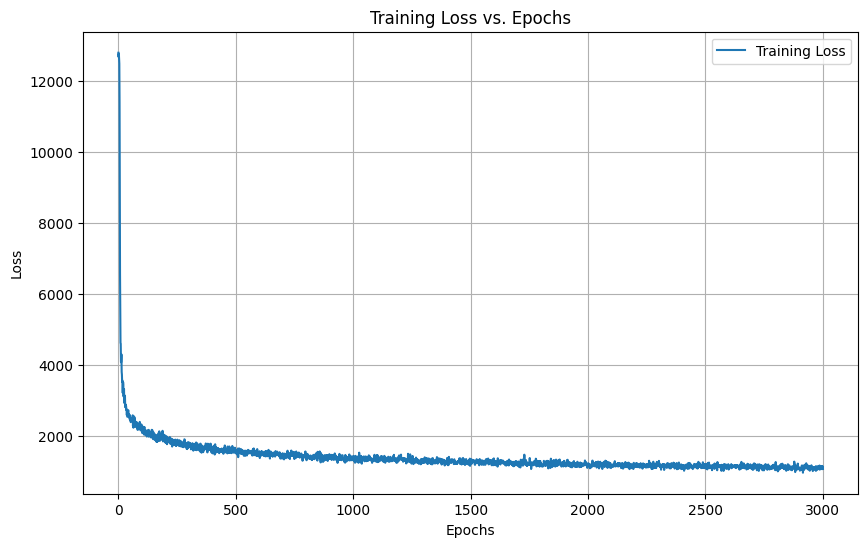

Test Loss: 4587.52783203125
Test R2: 0.5711012118342235
Test Bias (%): 4.419382095336914
Test RMSE W/m2: 36.92056655883789


c:\Users\rouhi\anaconda3\envs\dl\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([714])) that is different to the input size (torch.Size([714, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [136]:
## pytorch method of doing the same thing 
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error as MAPE

class NeuralNetwork(nn.Module):
    def __init__(self, input_shape, hidden_units=[128, 128, 128, 128, 128, 64], output_units=1, dropout_rate=0.5):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()

        # Define the layers dynamically based on the hidden_units list
        layers = []
        in_features = input_shape
        for hidden in hidden_units:
            layers.append(nn.Linear(in_features, hidden))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            in_features = hidden

        # Add the final output layer
        layers.append(nn.Linear(in_features, output_units))

        # Use nn.Sequential to combine the layers
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        x = self.flatten(x.to(torch.float32))
        x = self.network(x)
        return x
# def custom_loss_function(predictions, targets, inputs, alpha=0.5):
#     mse_loss = nn.MSELoss()(predictions, targets)
#     print("MSE LOSS=",mse_loss)
#     print(predictions.shape)
#     physics_loss = torch.sum(torch.abs(inputs[:, 14].unsqueeze(1)-inputs[:, 15].unsqueeze(1)-(inputs[:, 17].unsqueeze(1)*inputs[:, 18].unsqueeze(1)/predictions)))
#     normalized_physics_loss = physics_loss / torch.mean(torch.abs(inputs[:, 14] - inputs[:, 15] - (inputs[:, 17] * inputs[:, 18] / torch.mean(predictions))))

#     print("Additional LOSS=",normalized_physics_loss)

#     total_loss = mse_loss + alpha * normalized_physics_loss
#     return total_loss

def train_model(model, criterion, optimizer, x_train, y_train, epochs=3000, batch_size=400):
    model.train()
    dataset = torch.utils.data.TensorDataset(x_train, y_train)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    epoch_losses = []

    for epoch in range(epochs):
        running_loss = 0.0
        for batch_x, batch_y in dataloader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)

            # loss = criterion(outputs, batch_y, batch_x)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        # Calculate the average loss for the epoch
        epoch_loss = running_loss / len(dataloader)
        epoch_losses.append(epoch_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss}")

    return epoch_losses


def evaluate_model(model, x_test, y_test):
    model.eval()
    with torch.no_grad():
        outputs = model(x_test)
        loss = criterion(outputs, y_test)
    return loss.item()

def r2_calc(model, x_test, y_test):
    model.eval()
    with torch.no_grad():
        predictions = model(x_test).squeeze()
    return r2_score(y_test.numpy(), predictions.numpy())

def bias_calc(model, x_test, y_test):
    model.eval()
    with torch.no_grad():
        predictions = model(x_test).squeeze()
    return MAPE(y_test.numpy(), predictions.numpy())
def rmse_calc(model, x_test, y_test):
    model.eval()
    with torch.no_grad():
        predictions = model(x_test).squeeze()
    return rmse(y_test.numpy(), predictions.numpy())
# Example usage
# Assuming x_train, y_train, x_test, y_test are your training and testing data
# and have been converted to torch tensors.

input_shape = X_train.shape[1]
model = NeuralNetwork(input_shape)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=0.0005)
# optimizer=optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
# train_model(model, custom_loss_function, optimizer, X_train, train_labels)
epoch_losses = train_model(model, criterion, optimizer, X_train, train_labels)
# Plotting the loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss vs. Epochs')
plt.legend()
plt.grid(True)
plt.show()
test_loss = evaluate_model(model, X_test, test_labels)
print(f"Test Loss: {test_loss}")
print(f"Test R2: {r2_calc(model, X_test, test_labels)}")
print(f"Test Bias (%): {bias_calc(model, X_test, test_labels)}")
print(f"Test RMSE W/m2: {rmse_calc(model, X_test, test_labels)}")

In [141]:
## Testing with OpenET
## Let's compare the results of OpenET vs GEESEBAL vs ML model
## Read Open ET results
os.chdir("D:\\Backup\\Rouhin_Lenovo\\US_project\\Untitled_Folder\\Data\\Volk_merged\\ML_datasets\\Open_ET\\Sen1")
file_list_openet=os.listdir()
val_openet=[]
for i in range(len(file_list_openet)):
    for j in range(len(val)):
        if file_list_openet[i].split('.')[0]==val[j]["Site_name"].iloc[0]:
            tmp=pd.read_csv(file_list_openet[i],parse_dates=["Date"])
            val_openet.append(pd.merge(val[j].drop(columns={"Unnamed: 0_x"}),tmp,on="Date",how="left"))
for i in range(len(val_openet)):
    val_openet[i]["LE_openet"]=val_openet[i]["ETa"]*28.36

In [143]:
## Testing with OpenET 
features=features=['ALFA', 'Tao_sw_1', 'Rs_down',
       'Rl_down', 'Rl_up', 'Rn','VV_norm', 
       'VH_norm', 'VV_red', 'VV_green', 'VV_blue', 'VV_NIR', 'VV_SWIR1',
       'VV_SWIR2', 'VV_NDVI', 'VV_NDWI', 'VH_red', 'VH_green', 'VH_blue',
       'VH_NIR', 'VH_SWIR1', 'VH_SWIR2', 'VH_NDVI', 'VH_NDWI', 'VH_LST',
       'VV_LST', 'VH-VV',"Ginst","Hinst","LEinst","Gap","LE_Daily_model","LE_openet"]
labels=["LE_closed"]
# ml_df=df[["B","R","GR","NIR","SWIR_1","SWIR_2","NDVI","NDWI","ALFA","Rs_down","Rl_down","Rl_up","Rn","Ginst","Hinst","LEinst","LE_closed","LE_Daily_model"]]
# ml_df=ml_df.dropna()
# print(ml_df.shape)
# features=ml_df[["B","R","GR","NIR","SWIR_1","SWIR_2","NDVI","NDWI","ALFA","Rs_down","Rl_down","Rl_up","Rn","Ginst","Hinst","LEinst","LE_Daily_model"]]
# labels=ml_df["LE_closed"]
# print(features.shape)
## Create a train set to include the geesebal output 
# train_features_all=pd.concat(train)[features].dropna()
test_features_all=pd.concat(val_openet)[features].dropna()
# train_features=pd.concat(train)[features].dropna().drop(columns=["LE_Daily_model","LE_openet"])
train_features
test_features=pd.concat(val_openet)[features].dropna().drop(columns=["LE_Daily_model","LE_openet"])
X_test = scaler.transform(test_features)
print(X_test.shape)
# ## labels
test_labels=np.array(pd.concat(val_openet)[pd.concat(val_openet)["LE_openet"].notna()][labels]).squeeze()
print(test_labels.shape)
# ## labels ## For pytorch 
X_test=torch.tensor(X_test).to(torch.float32)
test_labels=torch.tensor(test_labels).to(torch.float32)



(277, 31)
(277,)


In [144]:
## For pytorch 
test_loss = evaluate_model(model, X_test, test_labels)
print(f"Test Loss: {test_loss}")
print(f"Test R2: {r2_calc(model, X_test, test_labels)}")
print(f"Test Bias (%): {bias_calc(model, X_test, test_labels)}")
print(f"Test RMSE W/m2: {rmse_calc(model, X_test, test_labels)}")
##--------
print("GEESEBAL accuracy (RMSE)=",rmse(test_labels,test_features_all["LE_Daily_model"]) )
print("GEESEBAL R2 =",r2_score(test_labels,test_features_all["LE_Daily_model"]) )
print("GEESEBAL MAPE =",MAPE(test_labels,test_features_all["LE_Daily_model"]) )
print("OpenET accuracy (RMSE)=",rmse(test_labels,test_features_all["LE_openet"]) )
print("OpenET R2 =",r2_score(test_labels,test_features_all["LE_openet"]) )
print("OpenET MAPE =",MAPE(test_labels,test_features_all["LE_openet"]) )

Test Loss: 5410.23779296875
Test R2: 0.3523276467439741
Test Bias (%): 0.45855191349983215
Test RMSE W/m2: 48.292579650878906
GEESEBAL accuracy (RMSE)= 59.9497665345855
GEESEBAL R2 = 0.0019103599461512966
GEESEBAL MAPE = 0.6541946691289369
OpenET accuracy (RMSE)= 41.362911343892364
OpenET R2 = 0.5248652947604846
OpenET MAPE = 0.5041483704220069


c:\Users\rouhi\anaconda3\envs\dl\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([277])) that is different to the input size (torch.Size([277, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [71]:
for i in range(len(val)):
    val[i].to_csv("D:\\Backup\\Rouhin_Lenovo\\US_project\\Untitled_Folder\\Data\\Volk_merged\\ML_datasets\\Val_Data_for_OpenET\\Sen1\\"+val[i]["Site_name"].iloc[0]+".csv")

In [14]:
## Get a df of train and val station data 
lat=[]
lon=[]
elev=[]
shape=[]
name=[]
lc=[]
for i in range(len(train)):
    lat.append(train[i]["Lat_volk"].iloc[0])
    lon.append(train[i]["Lon_volk"].iloc[0])
    elev.append(train[i]["Elev_volk"].iloc[0])
    lc.append(train[i]["Land_cover_volk"].iloc[0])
    name.append(train[i]["Site_name"].iloc[0])
    shape.append(train[i].shape[0])
summary_df_train=pd.DataFrame()
summary_df_train["Lat"]=lat
summary_df_train["Lon"]=lon
summary_df_train["Elev"]=elev
summary_df_train["lc"]=lc
summary_df_train["Name"]=name
summary_df_train["Points"]=shape
###-----------------
lat=[]
lon=[]
elev=[]
shape=[]
name=[]
lc=[]
for i in range(len(val)):
    lat.append(val[i]["Lat_volk"].iloc[0])
    lon.append(val[i]["Lon_volk"].iloc[0])
    elev.append(val[i]["Elev_volk"].iloc[0])
    lc.append(val[i]["Land_cover_volk"].iloc[0])
    name.append(val[i]["Site_name"].iloc[0])
    shape.append(val[i].shape[0])
summary_df_val=pd.DataFrame()
summary_df_val["Lat"]=lat
summary_df_val["Lon"]=lon
summary_df_val["Elev"]=elev
summary_df_val["lc"]=lc
summary_df_val["Name"]=name
summary_df_val["Points"]=shape
# summary_df_train.to_csv("D:\\Backup\\Rouhin_Lenovo\\US_project\\Untitled_Folder\\Data\\Volk_merged\\ML_datasets\\Train_test_sites\\ML_Sen1\\train_seed_sen_3.csv")
# summary_df_val.to_csv("D:\\Backup\\Rouhin_Lenovo\\US_project\\Untitled_Folder\\Data\\Volk_merged\\ML_datasets\\Train_test_sites\\ML_Sen1\\val_seed_sen_3.csv")